In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split


In [2]:
class SmallCNN4(nn.Module):
    def __init__(self, input_channels=10, num_classes=2):
        super(SmallCNN4, self).__init__()

        # First CNN Layer
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsample by 2

        # Depthwise Separable Convolution
        self.depthwise = nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32)
        self.pointwise = nn.Conv2d(32, 64, kernel_size=1)

        # Global Average Pooling to (2, 2)
        self.gap = nn.AdaptiveAvgPool2d((4, 4))

        # Fully Connected Layer
        self.fc = nn.Linear(64 * 4 * 4, num_classes)  # 64 channels with spatial size (2, 2)

    def forward(self, x):
        # First CNN Layer
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        # Depthwise Separable Convolution
        x = F.relu(self.pointwise(self.depthwise(x)))

        # Global Average Pooling
        x = self.gap(x).view(x.size(0), -1)

        # Fully Connected Layer
        x = self.fc(x)

        return x
    
    
super_model = SmallCNN4(num_classes=2).to('cuda')
print(f"Total parameters: {sum(p.numel() for p in super_model.parameters() if p.requires_grad)}")
summary(super_model, (10,50,50))

Total parameters: 7458
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]           2,912
       BatchNorm2d-2           [-1, 32, 50, 50]              64
         MaxPool2d-3           [-1, 32, 25, 25]               0
            Conv2d-4           [-1, 32, 25, 25]             320
            Conv2d-5           [-1, 64, 25, 25]           2,112
 AdaptiveAvgPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                    [-1, 2]           2,050
Total params: 7,458
Trainable params: 7,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 1.84
Params size (MB): 0.03
Estimated Total Size (MB): 1.96
----------------------------------------------------------------


In [3]:
class GeoTIFFDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images, organized in subfolders per class.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        
        for cls in self.classes:
            cls_folder = os.path.join(root_dir, cls)
            for file in os.listdir(cls_folder):
                if file.endswith('.tif') or file.endswith('.tiff'):
                    self.image_paths.append(os.path.join(cls_folder, file))
                    self.labels.append(self.class_to_idx[cls])
    
    def __len__(self):
        return len(self.image_paths)
    
    def compute_indices(self, bands):
        """
        Compute NDVI, SAVI, VARI, EXG, NDRE indices.
        Args:
            bands (numpy array): Array of shape (6, H, W)
        Returns:
            indices (numpy array): Array of shape (5, H, W)
        """
        # Assuming band order: 0=Blue, 1=Green, 2=Red, 3=NIR, 4=RE, 5=SWIR
        blue = bands[0].astype(float)
        green = bands[1].astype(float)
        red = bands[2].astype(float)
        re = bands[3].astype(float)
        nir = bands[4].astype(float)
        # swir = bands[5].astype(float)  # Not used in indices here
        
        # NDVI
        ndvi = (nir - red) / (nir + red + 1e-6)
        
        # SAVI (L=0.5)
        L = 0.5
        savi = ((nir - red) / (nir + red + L)) * (1 + L)
        
        # VARI
        vari = (green - red) / (green + red - blue + 1e-6)
        
        # EXG
        exg = 2 * green - red - blue
        
        # NDRE
        ndre = (nir - re) / (nir + re + 1e-6)
        
        # Stack indices
        indices = np.stack([ndvi, savi, vari, exg, ndre], axis=0)
        
        return indices
    
    def normalize(self, data):
        """
        Normalize each channel to have zero mean and unit variance.
        Args:
            data (numpy array): Array of shape (10, H, W)
        Returns:
            normalized_data (torch.Tensor): Normalized tensor
        """
        # Flatten to (C, H*W) for mean/std computation
        C, H, W = data.shape
        data_reshaped = data.reshape(C, -1)
        
        mean = data_reshaped.mean(axis=1, keepdims=True)
        std = data_reshaped.std(axis=1, keepdims=True) + 1e-6  # Prevent division by zero
        
        normalized = (data - mean.reshape(C, 1, 1)) / std.reshape(C, 1, 1)
        return normalized
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        with rasterio.open(img_path) as src:
            # bands = src.read()  # Shape: (6, H, W)
            bands = src.read(list(range(1, src.count)))
        
        indices = self.compute_indices(bands)  # Shape: (10, H, W)
        
        # Stack original bands with indices
        data = np.concatenate([bands, indices], axis=0)  # Shape: (10, H, W)
        
        # Normalize
        data = self.normalize(data)
        
        # Convert to float32
        data = data.astype(np.float32)
        
        # Apply transformations if any (e.g., data augmentation)
        if self.transform:
            data = self.transform(data)
        
        # Convert to torch tensor
        tensor = torch.from_numpy(data)
        
        return tensor, label

In [4]:
def train_and_validate_with_test(
    model, 
    train_loader, 
    val_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler=None, 
    num_epochs=50, 
    patience=10, 
    device='cuda'
):
    best_model_weights = None
    best_val_loss = float('inf')
    train_loss_history, val_loss_history = [], []
    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)
        train_loss_history.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        val_loss_history.append(val_loss)

        # Check early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break

        # Step the scheduler
        if scheduler:
            scheduler.step(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_weights)

    # Testing phase
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    cm = confusion_matrix(all_labels, all_preds)
    return train_loss_history, val_loss_history, cm, model

Starting Fold 1
Epoch 1/100 - Train Loss: 0.6633, Val Loss: 0.6773
Epoch 2/100 - Train Loss: 0.6426, Val Loss: 0.6551
Epoch 3/100 - Train Loss: 0.6224, Val Loss: 0.6225
Epoch 4/100 - Train Loss: 0.5566, Val Loss: 0.6007
Epoch 5/100 - Train Loss: 0.4755, Val Loss: 0.4891
Epoch 6/100 - Train Loss: 0.3618, Val Loss: 0.3855
Epoch 7/100 - Train Loss: 0.3083, Val Loss: 0.3551
Epoch 8/100 - Train Loss: 0.2521, Val Loss: 0.2935
Epoch 9/100 - Train Loss: 0.2499, Val Loss: 0.2686
Epoch 10/100 - Train Loss: 0.2447, Val Loss: 0.2759
Epoch 11/100 - Train Loss: 0.2159, Val Loss: 0.2813
Epoch 12/100 - Train Loss: 0.1901, Val Loss: 0.2712
Epoch 13/100 - Train Loss: 0.1762, Val Loss: 0.2239
Epoch 14/100 - Train Loss: 0.1553, Val Loss: 0.2209
Epoch 15/100 - Train Loss: 0.1768, Val Loss: 0.2611
Epoch 16/100 - Train Loss: 0.2606, Val Loss: 0.1993
Epoch 17/100 - Train Loss: 0.1356, Val Loss: 0.2778
Epoch 18/100 - Train Loss: 0.1285, Val Loss: 0.2086
Epoch 19/100 - Train Loss: 0.1140, Val Loss: 0.1834
Epoch

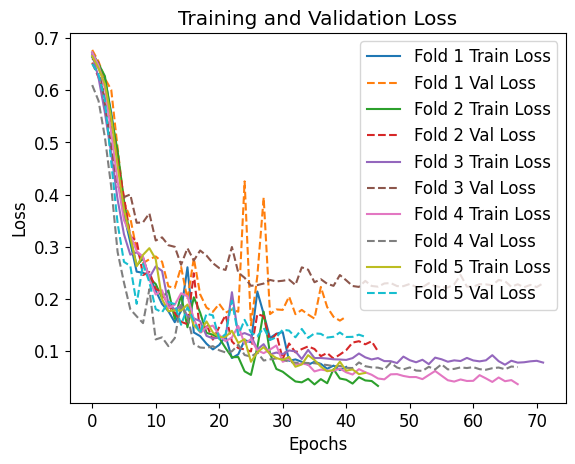

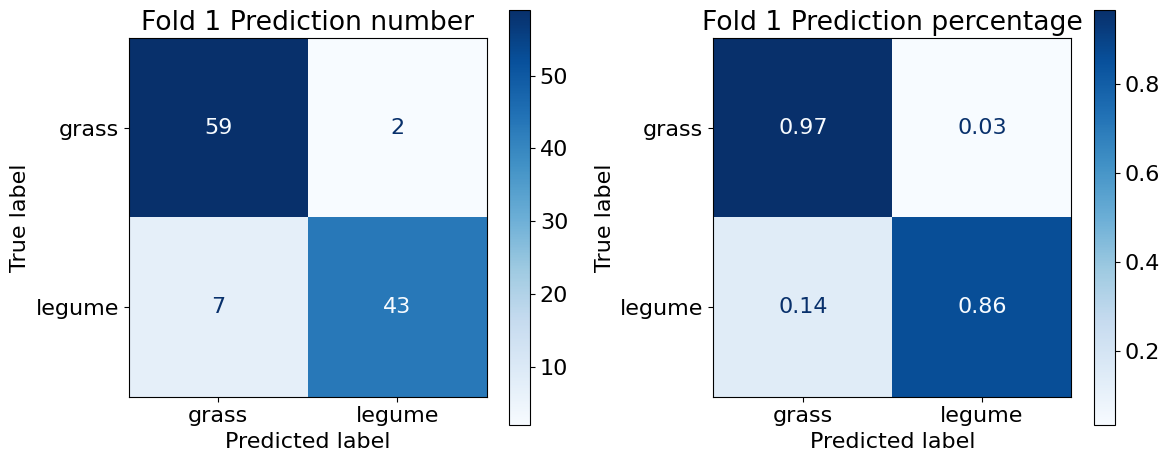

Fold 1 - Grass: Precision: 0.8939, Recall: 0.9672, Specificity: 0.8600, F1 Score: 0.9291
Fold 1 - Legume: Precision: 0.9556, Recall: 0.8600, Specificity: 0.9672, F1 Score: 0.9053
Fold 1 - Average: Precision: 0.9247, Recall: 0.9136, Specificity: 0.9136, F1 Score: 0.9172


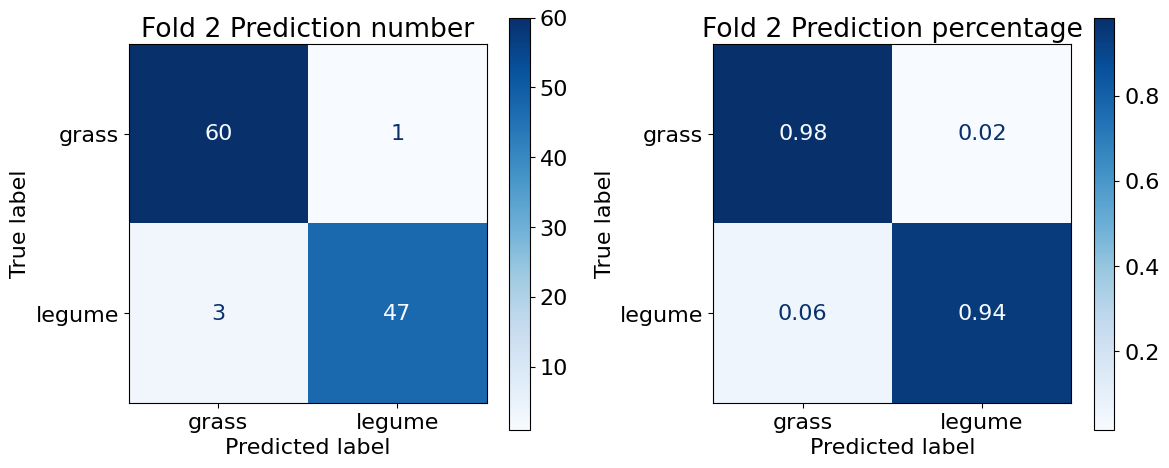

Fold 2 - Grass: Precision: 0.9524, Recall: 0.9836, Specificity: 0.9400, F1 Score: 0.9677
Fold 2 - Legume: Precision: 0.9792, Recall: 0.9400, Specificity: 0.9836, F1 Score: 0.9592
Fold 2 - Average: Precision: 0.9658, Recall: 0.9618, Specificity: 0.9618, F1 Score: 0.9635


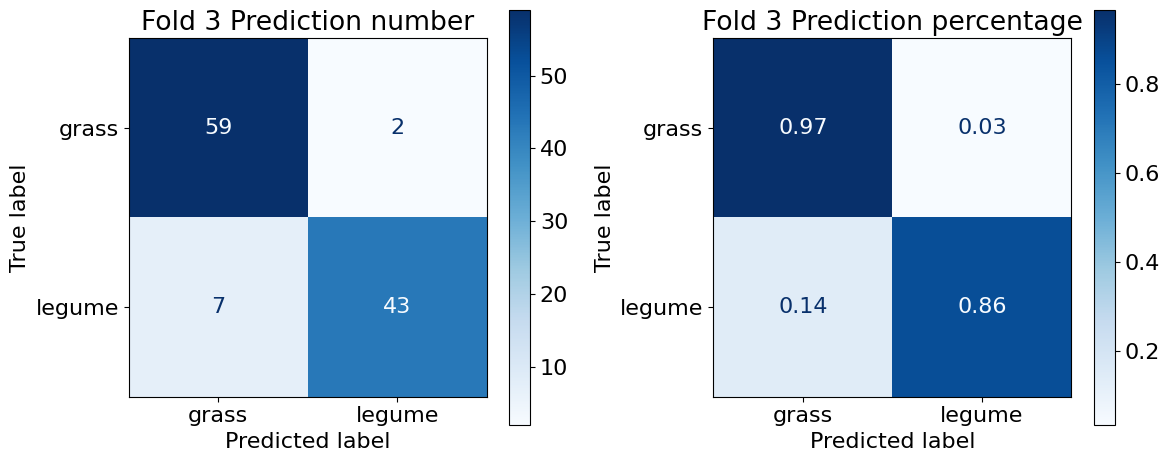

Fold 3 - Grass: Precision: 0.8939, Recall: 0.9672, Specificity: 0.8600, F1 Score: 0.9291
Fold 3 - Legume: Precision: 0.9556, Recall: 0.8600, Specificity: 0.9672, F1 Score: 0.9053
Fold 3 - Average: Precision: 0.9247, Recall: 0.9136, Specificity: 0.9136, F1 Score: 0.9172


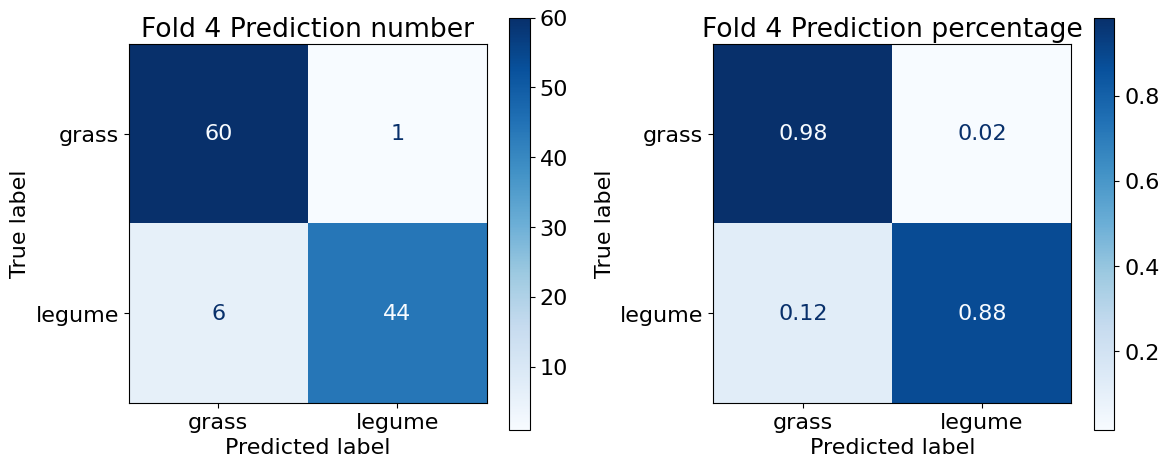

Fold 4 - Grass: Precision: 0.9091, Recall: 0.9836, Specificity: 0.8800, F1 Score: 0.9449
Fold 4 - Legume: Precision: 0.9778, Recall: 0.8800, Specificity: 0.9836, F1 Score: 0.9263
Fold 4 - Average: Precision: 0.9434, Recall: 0.9318, Specificity: 0.9318, F1 Score: 0.9356


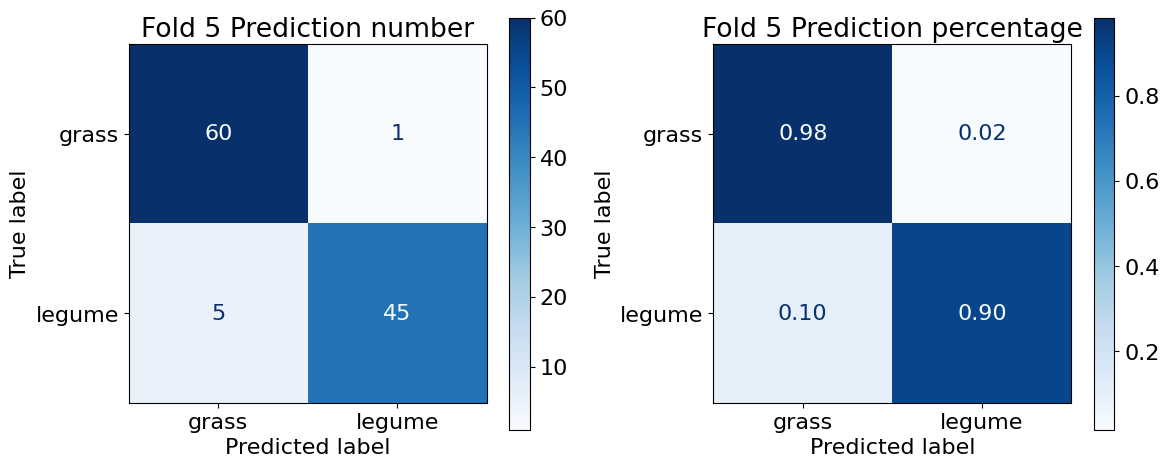

Fold 5 - Grass: Precision: 0.9231, Recall: 0.9836, Specificity: 0.9000, F1 Score: 0.9524
Fold 5 - Legume: Precision: 0.9783, Recall: 0.9000, Specificity: 0.9836, F1 Score: 0.9375
Fold 5 - Average: Precision: 0.9507, Recall: 0.9418, Specificity: 0.9418, F1 Score: 0.9449


In [5]:
# Example: No additional transformations 50 pixel
train_transform = None
test_transform = None
# Paths to training and testing folders
train_dir = './data/patch_50/train'
test_dir = './data/patch_50/test'

# Create dataset instances
train_dataset = GeoTIFFDataset(root_dir=train_dir, transform=train_transform)
test_dataset = GeoTIFFDataset(root_dir=test_dir, transform=test_transform)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_dataset.classes)  # Number of classes based on dataset

# model = SimpleCNN(num_classes=num_classes).to(device)
model = SmallCNN4(num_classes=num_classes).to(device)

# Step 3: Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 5: Perform Cross-Validation
fold_results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Starting Fold {fold + 1}")
    
    # Split into train and val
    train_data = Subset(train_dataset, train_idx)
    val_data = Subset(train_dataset, val_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Initialize model, criterion, optimizer, and scheduler
    model = SmallCNN4(input_channels=10, num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Train and validate the model
    train_loss, val_loss, cm, model = train_and_validate_with_test(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=100,
        patience=15,
        device=device
    )

    # Save results for this fold
    fold_results.append({
        'fold': fold + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'confusion_matrix': cm
    })

plt.rcParams.update({'font.size': 12})
# Step 6: Analyze Results
for result in fold_results:
    print(f"Fold {result['fold']}:")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    plt.plot(result['train_loss'], label=f"Fold {result['fold']} Train Loss")
    plt.plot(result['val_loss'], label=f"Fold {result['fold']} Val Loss", linestyle='dashed')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.savefig('./20250118_5-foldcv_lossplot_50.png') 
plt.show()

plt.rcParams.update({'font.size': 16})
# Step 1: Extract and sum confusion matrices
combined_cm = np.zeros_like(fold_results[0]['confusion_matrix'])  # Initialize a matrix of the same shape


for result in fold_results:
    cm = result['confusion_matrix']
    combined_cm += result['confusion_matrix']

    norm_cm = cm / cm.sum(axis=1, keepdims=True)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    disp = ConfusionMatrixDisplay(cm, display_labels=train_dataset.classes)
    disp.plot(cmap='Blues', xticks_rotation='horizontal', ax=axes[0])
    axes[0].set_title(f'Fold {result["fold"]} Prediction number')
    axes[0].set_ylabel('True label', rotation='vertical')

    disp = ConfusionMatrixDisplay(norm_cm, display_labels=train_dataset.classes)
    disp.plot(cmap='Blues', xticks_rotation='horizontal', values_format=".2f", ax=axes[1])
    axes[1].set_title(f'Fold {result["fold"]} Prediction percentage')
    axes[1].set_ylabel('True label', rotation='vertical')

    plt.tight_layout()
    plt.show()

    grass_precision = cm[0,0] / (cm[0,0] + cm[1,0] + 1e-6)
    grass_recall = cm[0,0] / (cm[0,0] + cm[0,1] + 1e-6)
    grass_sensitivity = grass_recall
    grass_specificity = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-6)
    grass_f1 = 2 * (grass_precision * grass_recall) / (grass_precision + grass_recall + 1e-6)

    legume_precision = cm[1,1] / (cm[1,1] + cm[0,1] + 1e-6)
    legume_recall = cm[1,1] / (cm[1,1] + cm[1,0] + 1e-6)
    legume_sensitivity = legume_recall
    legume_specificity = cm[0,0] / (cm[0,0] + cm[0,1] + 1e-6)
    legume_f1 = 2 * (legume_precision * legume_recall) / (legume_precision + legume_recall + 1e-6)

    avg_precision = (grass_precision + legume_precision) / 2
    avg_sensitivity = (grass_sensitivity + legume_sensitivity) / 2
    avg_specificity = (grass_specificity + legume_specificity) / 2
    avg_f1 = (grass_f1 + legume_f1) / 2

    print(f"Fold {result['fold']} - Grass: Precision: {grass_precision:.4f}, Recall: {grass_recall:.4f}, Specificity: {grass_specificity:.4f}, F1 Score: {grass_f1:.4f}")
    print(f"Fold {result['fold']} - Legume: Precision: {legume_precision:.4f}, Recall: {legume_recall:.4f}, Specificity: {legume_specificity:.4f}, F1 Score: {legume_f1:.4f}")
    print(f"Fold {result['fold']} - Average: Precision: {avg_precision:.4f}, Recall: {avg_sensitivity:.4f}, Specificity: {avg_specificity:.4f}, F1 Score: {avg_f1:.4f}")
    
# # Normalize the combined confusion matrix (optional)
# combined_cm_normalized = combined_cm / combined_cm.sum(axis=1, keepdims=True)

# # # Plot the combined confusion matrix
# disp = ConfusionMatrixDisplay(combined_cm, display_labels=train_dataset.classes)
# disp.plot(cmap='Blues', xticks_rotation='horizontal')
# plt.title('Prediction number')
# plt.yticks(rotation="vertical")
# plt.savefig('./20250118_5-foldcv_cm_num_50.png') 
# plt.show()


# disp = ConfusionMatrixDisplay(combined_cm_normalized, display_labels=train_dataset.classes)
# disp.plot(cmap='Blues', xticks_rotation='horizontal', values_format=".2f")
# plt.title('Prediction percentage')
# plt.yticks(rotation="vertical")
# plt.savefig('./20250118_5-foldcv_cm_percentage_50.png') 
# plt.show() 

Fold 1:
Confusion Matrix:
[[52  0]
 [ 5 32]]
Fold 2:
Confusion Matrix:
[[56  2]
 [ 2 29]]
Fold 3:
Confusion Matrix:
[[51  2]
 [ 2 34]]
Fold 4:
Confusion Matrix:
[[60  0]
 [ 1 27]]
Fold 5:
Confusion Matrix:
[[52  3]
 [ 7 26]]


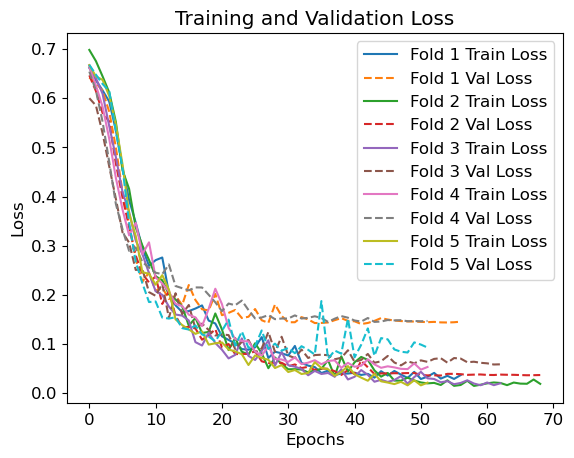

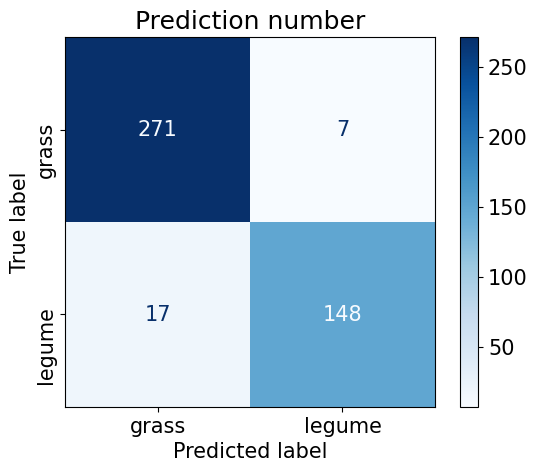

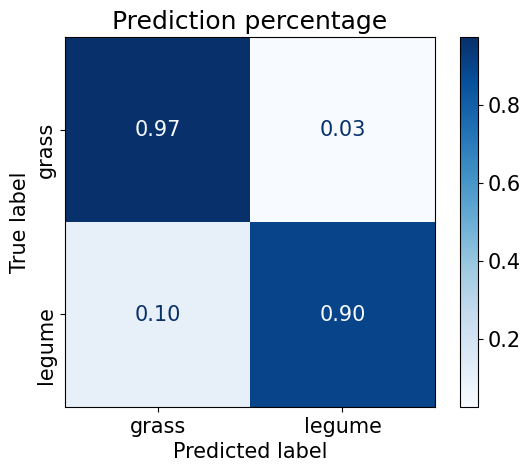

In [9]:
plt.rcParams.update({'font.size': 12})
# Step 6: Analyze Results
for result in fold_results:
    print(f"Fold {result['fold']}:")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    plt.plot(result['train_loss'], label=f"Fold {result['fold']} Train Loss")
    plt.plot(result['val_loss'], label=f"Fold {result['fold']} Val Loss", linestyle='dashed')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.savefig('./20250118_5-foldcv_lossplot_50.png') 
plt.show()

plt.rcParams.update({'font.size': 15})
# Step 1: Extract and sum confusion matrices
combined_cm = np.zeros_like(fold_results[0]['confusion_matrix'])  # Initialize a matrix of the same shape

for result in fold_results:
    combined_cm += result['confusion_matrix']

    
# # Normalize the combined confusion matrix (optional)
combined_cm_normalized = combined_cm / combined_cm.sum(axis=1, keepdims=True)

# # Plot the combined confusion matrix
disp = ConfusionMatrixDisplay(combined_cm, display_labels=full_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation='horizontal')
plt.title('Prediction number')
plt.yticks(rotation="vertical")
plt.savefig('./20250118_5-foldcv_cm_num_50.png') 
plt.show()


disp = ConfusionMatrixDisplay(combined_cm_normalized, display_labels=full_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation='horizontal', values_format=".2f")
plt.title('Prediction percentage')
plt.yticks(rotation="vertical")
plt.savefig('./20250118_5-foldcv_cm_percentage_50.png') 
plt.show() 

Epoch 1/100 - Train Loss: 0.6669, Val Loss: 0.6279
Epoch 2/100 - Train Loss: 0.6376, Val Loss: 0.6110
Epoch 3/100 - Train Loss: 0.6049, Val Loss: 0.5678
Epoch 4/100 - Train Loss: 0.5335, Val Loss: 0.4984
Epoch 5/100 - Train Loss: 0.4328, Val Loss: 0.3943
Epoch 6/100 - Train Loss: 0.3647, Val Loss: 0.3516
Epoch 7/100 - Train Loss: 0.3352, Val Loss: 0.3206
Epoch 8/100 - Train Loss: 0.2990, Val Loss: 0.2996
Epoch 9/100 - Train Loss: 0.3101, Val Loss: 0.3206
Epoch 10/100 - Train Loss: 0.2918, Val Loss: 0.2528
Epoch 11/100 - Train Loss: 0.2331, Val Loss: 0.2440
Epoch 12/100 - Train Loss: 0.2819, Val Loss: 0.2577
Epoch 13/100 - Train Loss: 0.2308, Val Loss: 0.2317
Epoch 14/100 - Train Loss: 0.2013, Val Loss: 0.2017
Epoch 15/100 - Train Loss: 0.1824, Val Loss: 0.2017
Epoch 16/100 - Train Loss: 0.1724, Val Loss: 0.1838
Epoch 17/100 - Train Loss: 0.1627, Val Loss: 0.1834
Epoch 18/100 - Train Loss: 0.1903, Val Loss: 0.2388
Epoch 19/100 - Train Loss: 0.1764, Val Loss: 0.1752
Epoch 20/100 - Train 

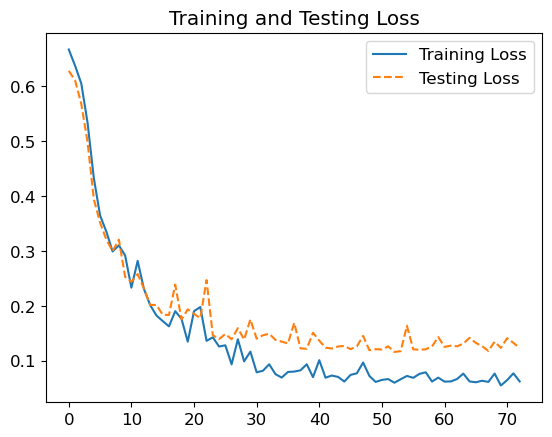

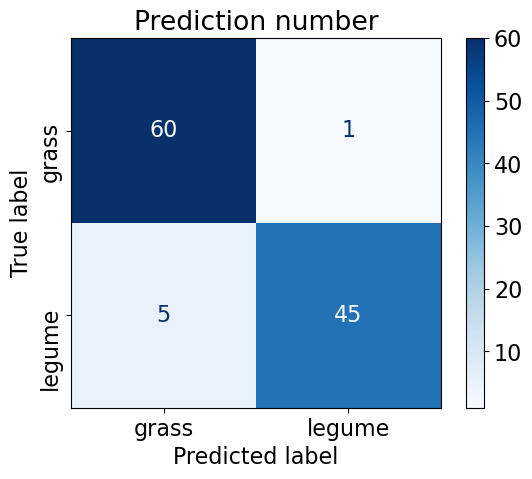

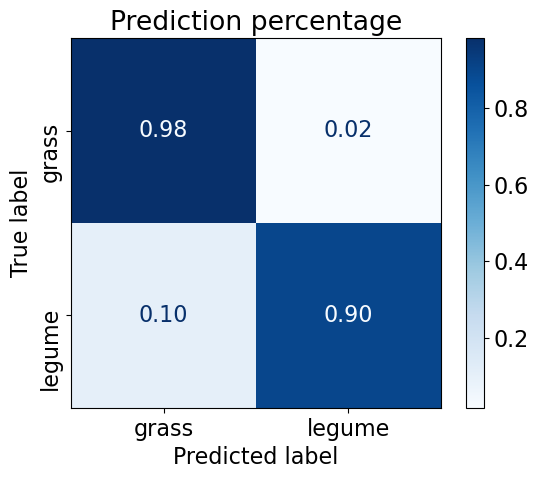

In [7]:
# Example: training (train and validation) and testing folder 50 pixel
train_transform = None
test_transform = None
# Paths to training and testing folders
train_dir = '/blue/changzhao/zhou.tang/botanical_composition/data/patch_50/train'
test_dir = '/blue/changzhao/zhou.tang/botanical_composition/data/patch_50/test'

# Create dataset instances
train_val_data = GeoTIFFDataset(root_dir=train_dir, transform=train_transform)
test_data = GeoTIFFDataset(root_dir=test_dir, transform=test_transform)

# Further split train_val into train and val (80% train, 20% val)
train_size = int(0.8 * len(train_val_data))
val_size = len(train_val_data) - train_size
train_data, val_data = random_split(train_val_data, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

# Initialize model, criterion, optimizer, and scheduler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(test_data.classes)  # Number of classes based on dataset
model = SmallCNN4(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Train and validate the model
train_loss, val_loss, cm, model = train_and_validate_with_test(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=100,
    patience=20,
    device=device
)

torch.save(model.state_dict(), 'best_model_20250118_50_smallmodel4.pth')

# Plot Losses
plt.rcParams.update({'font.size': 12})
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss', linestyle='dashed')
plt.legend()
plt.title(f'Training and Testing Loss')
plt.savefig('./20250118_train_testing_lossplot_50_smallmodel4.png') 
plt.show()


plt.rcParams.update({'font.size': 16})
# # Normalize the combined confusion matrix (optional)
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# # Plot the combined confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=test_data.classes)
disp.plot(cmap='Blues', xticks_rotation='horizontal')
plt.title('Prediction number')
plt.yticks(rotation="vertical")
plt.savefig('./20250118_CM_number_Test_50_smallmodel4.png')
plt.show()

disp = ConfusionMatrixDisplay(cm_normalized, display_labels=test_data.classes)
disp.plot(cmap='Blues', xticks_rotation='horizontal', values_format=".2f")
plt.title('Prediction percentage')
plt.yticks(rotation="vertical")
plt.savefig('./20250118_CM_percentage_Test_50_smallmodel4.png')
plt.show() 

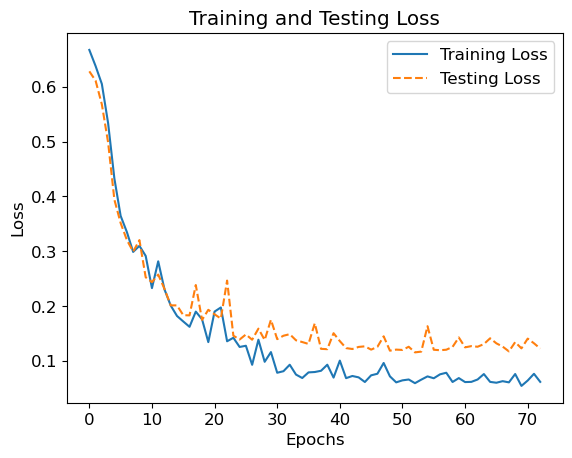

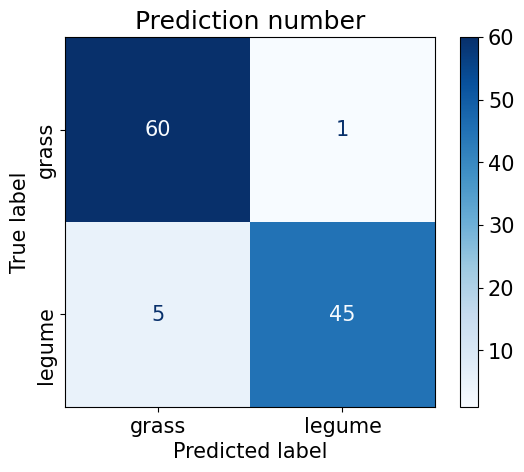

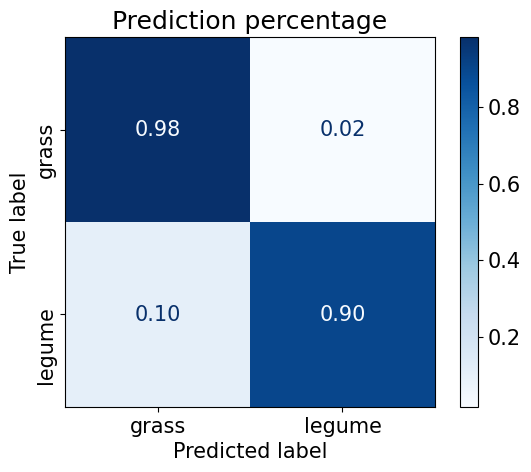

In [11]:
# Plot Losses
plt.rcParams.update({'font.size': 12})
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Testing Loss', linestyle='dashed')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Training and Testing Loss')
plt.savefig('./20250118_train_testing_lossplot_50_smallmodel4.png') 
plt.show()


plt.rcParams.update({'font.size': 15})
# # Normalize the combined confusion matrix (optional)
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# # Plot the combined confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=test_data.classes)
disp.plot(cmap='Blues', xticks_rotation='horizontal')
plt.title('Prediction number')
plt.yticks(rotation="vertical")
plt.savefig('./20250118_CM_number_Test_50_smallmodel4.png')
plt.show()

disp = ConfusionMatrixDisplay(cm_normalized, display_labels=test_data.classes)
disp.plot(cmap='Blues', xticks_rotation='horizontal', values_format=".2f")
plt.title('Prediction percentage')
plt.yticks(rotation="vertical")
plt.savefig('./20250118_CM_percentage_Test_50_smallmodel4.png')
plt.show() 